# **Challenge 1: Finding our Feature Space**
* Sahil Gill, Luke Ingram
* MATH 318 - Winter 2023

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
import glob
import random

## **Section 1 - Introduction**
### **The Dataset:** 

We'll be using the **Garbage Classification** dasaset linked here: <https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification>

This is a supervised learning dataset, which contains 2527 images belonging to six classes. Cardboard (393), glass (491), metal (400), paper (584), plastic (472) and trash (127).

Here's a sample image from each class:

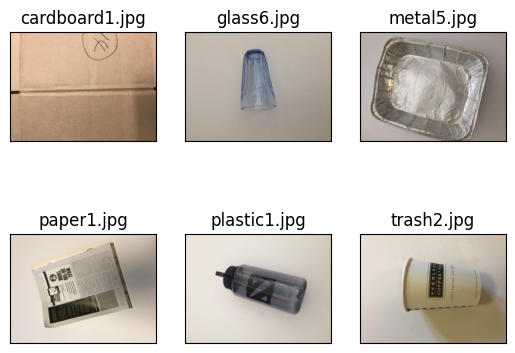

In [2]:
# Define paths
basepath = "../src/data/archive/Garbage_classification/"
fnames = ["cardboard1.jpg","glass6.jpg","metal5.jpg",
          "paper1.jpg","plastic1.jpg","trash2.jpg"]
    
# Get samples
samples = [
    cv2.imread(f"{basepath}cardboard/{fnames[0]}"),
    cv2.imread(f"{basepath}glass/{fnames[1]}"),
    cv2.imread(f"{basepath}metal/{fnames[2]}"),
    cv2.imread(f"{basepath}paper/{fnames[3]}"),
    cv2.imread(f"{basepath}plastic/{fnames[4]}"),
    cv2.imread(f"{basepath}trash/{fnames[5]}")
]

# Define & Display
fig,axes = plt.subplots(2,3,subplot_kw={'xticks':(),'yticks':()})

for sample,ax,fname in zip(samples,axes.flatten(),fnames):
    _ = ax.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    _ = ax.set_title(fname)

plt.show()

As you may have guessed, we are tackling a classification problem.

But we've got all these images, where do we start?

## **Section 2 - Extracting Information from Images**
Before we make any predictions, we need to understand how we obtain real-valued information from our images.

### **Section 2.1 - Raw Pixel Data**
If you've ever played around with the MNIST handwritten digit recognition dataset, or watched some introductory videos about computer vision, then an intuitively simple approach would be to enumerate all of the pixel data into a massive array.

Since all the images in our dataset are 512x384, converting all our images to grayscale yields a feature space of 196608. Now if we consider our three color channels, our space would grow to a monstrous 589824 features.

We may perform dimensionality reduction methods such as PCA to reduce this number. Although, these computations will prove to be both time and memory intensive.

Evaluation of the Raw Pixel Data method is to come, but first we explore a more sophisticated approach.

### **Section 2.2 - Keypoints**

If you were on a beach staring into the ocean, would you really look at every crease of every wave that comes towards you? When you look at a rather uneventful photo of a forest, what do you look at? It is far too complex and unnecessary for our brains to process every piece of information that is fed to our eyes.

Human eyes have become keen to "anomalies" in whatever scene you might be observing, be it some sailboat out in a body of water or a house in the woods. In a scene of constant, unchanging information, our eyes are more likely to notice things that are extreme relative to the rest of the scene. In computer vision, these extrema in images are referred to as **keypoints**.

![](images/image-1633028732.png)

Obtaining keypoints is quite expensive and convoluted. To do so, a mathematical technique called *convolutions* are required, where a "window of values" is slowly moved over every portion of an image. This window of values, also called a kernel, is dotted with whatever portion of an image the kernel was over. Using this convolution technique, we can blur images using a *Gaussian Kernel* and take the difference of this blurred version with the previous (unblurred) version of the image.

Using these difference images, we can find extrema, which are defined as keypoints. However, because of the blurs induced on the image, we may need to look at a subsampled image to find keypoints that we might have missed by looking at the scene too broadly.

![](images/image-607433071.png)


We obtain a "pyramid" of difference images. Every time the image is subsampled, we add a layer, or an *octave* to the pyramid.

Here's the intuition: blurring an image required context. We couldn't look at a single pixel in an image and determine how to blur it. We need contextual information of the pixels that surround each pixel in order to blur convincingly. This context (reflected in the difference images), allows us to essentially tone down every "uninformative pixel", and highlight the extreme pixels--the keypoints.

### **Section 2.3 - The SIFT **(Scale Invariant Feature Transform)** Algorithm**

Keypoints are critical for representing images without extraneous, uninteresting information. However, keypoints cannot contain perfect information about the entirety of an image. The authors who introduced their concepts of keypoints created an extension of said keypoints: the **Scale Invariant Feature Transform**, or **SIFT**.

The **SIFT** framework essentially computes a $16 \times 16$ region around every keypoint that was computed using the algorithm in the previous section. Given this window around the keypoint, SIFT breaks down the window into $4\times4$ sub-windows.

![](images/image-1364412822.png)

For every one of these sub-windows, we compute a histogram where there are 8 bins of angle ranges. The gradient of every pixel in this subwindow is added to the respective bin with the gradient's corresponding angle, encoding even more information about directional changes in an image.

![](images/image-2039732114.png)

We'll use opencv to generate our keypoints.

In [ ]:
# Take Samples from section 1 
sift = cv2.SIFT_create()
kp_samples = [
  cv2.drawKeypoints(samples[1],sift.detect(samples[1]),samples[1],
          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS),
  cv2.drawKeypoints(samples[2],sift.detect(samples[2]),samples[2],
          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  ]

# Display keypoints found with SIFT
fig,axes = plt.subplots(1,2,subplot_kw={'xticks':(),'yticks':()})
for sample,ax in zip(kp_samples,axes.flatten()):
    _ = ax.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))

plt.show()